# **UEFA EURO**

---

**NOTEBOOK 1: UEFA EURO DATA COLLECTION AND PRE-PROCESSING**

---

**AUTHOR**

---



- Elmander

**TABLE OF CONTENT**

---



1.   STEP 1: SCRAPING.

     STEP 1 - PHASE 1: Creating Direct Download API.

     STEP 1 - PHASE 2: Extracting Downloaded Zipped Data.

2.   STEP 2: PRE-PROCESSING.

     STEP 2 - PHASE 1A: Managing Date-Time Values and Range.

     STEP 2 - PHASE 1B: Filtering Teams for Relevant Competition.

     STEP 2 - PHASE 2A: Calculating Winning Teams.

     STEP 2 - PHASE 2B: Label Encoding Data.

     STEP 2 - PHASE 3: Removing Outliers.

     STEP 2 - PHASE 4: Saving Clean Data.


**PROBLEM STATEMENT**

---



- Acquisition of UEFA Euro data for Data Analysis.
- Preparation of UEFA Euro data for Machine Learning.

**SOLUTION**

---



- We are going to use the following schematic to guide us on our work.

---

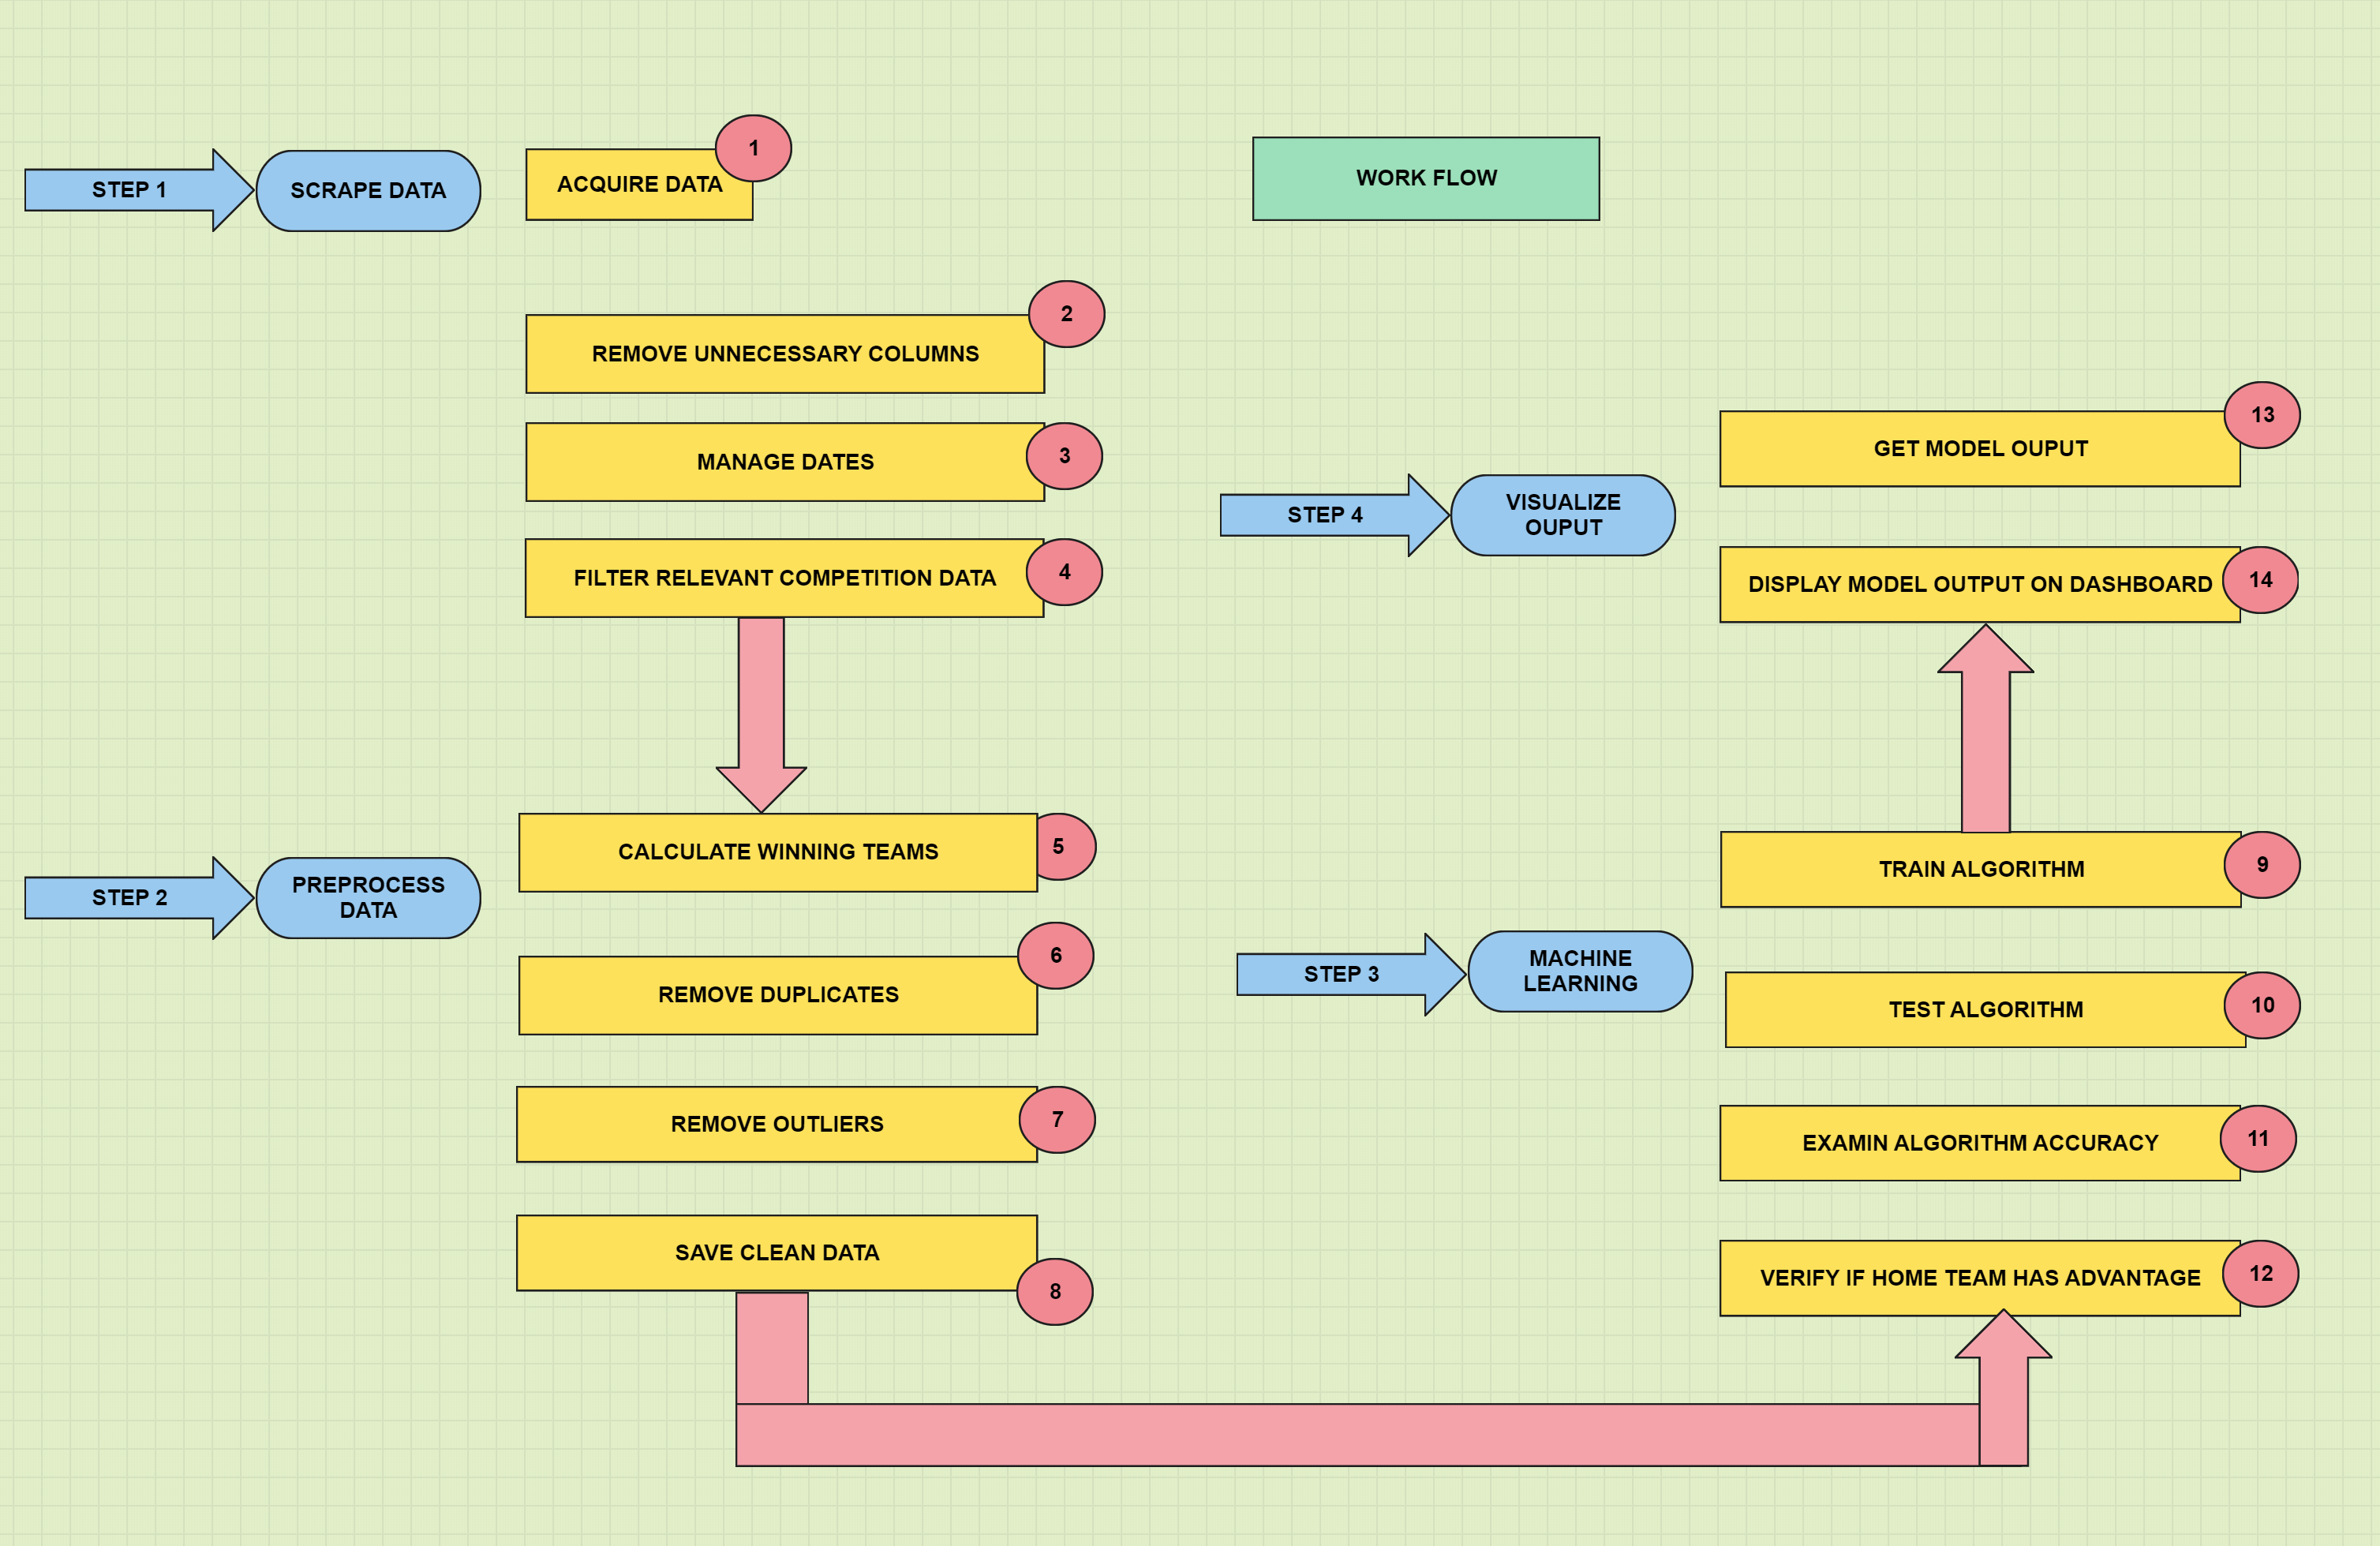

---

**REFERENCES**

---

For more information about the datasets used in this notebook, read the full documentation through the following links;

**DOCUMENT 1**: [GITHUB DATA](https://github.com/martj42/international_results)

**DOCUMENT 2**: [KAGGLE DATA](https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017?select=results.csv)

**TO DO LIST**

---

1. Create Direct Download API. ✅
2. Extract Downloaded Zipped Data. ✅
3. Manage Date-Time Values. ✅
4. Manage Date-Time Range. ✅
5. Filter Relevant Teams and Competitions. ✅
6. Calculate Winning Teams. ✅
7. Label Encode Data. ✅
8. Remove Outliers. ✅
9. Save Clean Data. ✅
10. Publish on DagsHub. ✅

---

In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests, os, zipfile, shutil
from pandas.errors import ParserError
from sklearn.preprocessing import LabelEncoder

In [2]:
def download_from_url(url, filename, save_directory):
    response = requests.get(url)
    if response.status_code == 200:
        zip_path = os.path.join(save_directory, filename)
        with open(zip_path, 'wb') as file:
            file.write(response.content)
        print(f"Downloaded {filename} and saved in {save_directory}")
        extract_dir = os.path.join(save_directory, filename.split('.')[0])
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        os.remove(zip_path)
        results_path = os.path.join(extract_dir, 'international_results-master', 'results.csv')
        if os.path.exists(results_path):
            shutil.move(results_path, save_directory)
            print(f"Moved 'results.csv' to {save_directory}")
        else:
            print(f"'results.csv' not found in {extract_dir}")
        shutil.rmtree(extract_dir)
        for root, dirs, files in os.walk(save_directory):
            for file in files:
                if file != 'results.csv':
                    os.remove(os.path.join(root, file))
            for dir in dirs:
                shutil.rmtree(os.path.join(root, dir))
    else:
        print(f"Failed to download {filename}")

In [3]:
url = 'https://github.com/martj42/international_results/archive/refs/heads/master.zip'
filename = 'master.zip'
save_directory = "Data/annual-data/"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)
download_from_url(url, filename, save_directory)

Downloaded master.zip and saved in Data/annual-data/
Moved 'results.csv' to Data/annual-data/


In [4]:
data = pd.read_csv('Data/annual-data/results.csv')
data = data.dropna(how='all')
data = data.dropna(axis=1, how='all')
data['date'] = pd.to_datetime(data['date'], dayfirst=True)
data = data.sort_values(by='date', ascending=False)
data = data.reset_index(drop=True)
data['date'] = data['date'].dt.strftime('%d/%m/%Y')
print(data.head(5))

C:\Users\elmer\AppData\Local\Temp\ipykernel_12208\2790776549.py:4: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  data['date'] = pd.to_datetime(data['date'], dayfirst=True)


         date home_team away_team  home_score  away_score    tournament  \
0  14/07/2024       NaN       NaN         NaN         NaN  Copa América   
1  14/07/2024       NaN       NaN         NaN         NaN     UEFA Euro   
2  13/07/2024       NaN       NaN         NaN         NaN  Copa América   
3  10/07/2024       NaN       NaN         NaN         NaN  Copa América   
4  10/07/2024       NaN       NaN         NaN         NaN     UEFA Euro   

            city        country  neutral  
0  Miami Gardens  United States     True  
1         Berlin        Germany     True  
2      Charlotte  United States     True  
3      Charlotte  United States     True  
4       Dortmund        Germany     True  


In [5]:
data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y', dayfirst=True)
start_date = '01/08/1950'
end_date = '31/07/2024'
data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]
data = data.sort_values(by='date', ascending=False)
data['tournament'] = data['tournament'].str.strip()
data = data[data['tournament'].isin(['UEFA Euro'])]
data['GoalDifference'] = data['home_score'] - data['away_score']
data['FTR'] = data['GoalDifference'].apply(lambda x: 'H' if x > 0 else ('A' if x < 0 else 'D'))
data.rename(columns={'date': 'Date', 'home_team': 'HomeTeam', 'away_team': 'AwayTeam', 'home_score': 'FTHG', 'away_score': 'FTAG', 'tournament': 'Tournament', 'city': 'CityVenue', 'country': 'CountryVenue', 'neutral': 'VenueNeutrality'}, inplace=True)
columns_of_interest = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'GoalDifference', 'FTR', 'Tournament', 'CityVenue', 'CountryVenue', 'VenueNeutrality']
data = data[columns_of_interest]
data.tail(5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,GoalDifference,FTR,Tournament,CityVenue,CountryVenue,VenueNeutrality
41341,1964-06-17,Denmark,Russia,0.0,3.0,-3.0,A,UEFA Euro,Barcelona,Spain,True
42330,1960-07-10,Russia,Yugoslavia,2.0,1.0,1.0,H,UEFA Euro,Paris,France,True
42332,1960-07-09,France,Czechoslovakia,0.0,2.0,-2.0,A,UEFA Euro,Marseille,France,False
42334,1960-07-06,Czechoslovakia,Russia,0.0,3.0,-3.0,A,UEFA Euro,Marseille,France,True
42335,1960-07-06,France,Yugoslavia,4.0,5.0,-1.0,A,UEFA Euro,Paris,France,False


In [6]:
label_encoder = LabelEncoder()
data.dropna(inplace=True)
data.drop_duplicates(inplace=True)
data['FTR'] = label_encoder.fit_transform(data['FTR'])
print(label_encoder.classes_)

['A' 'D' 'H']


In [7]:
mean_fthg = data['FTHG'].mean()
std_fthg = data['FTHG'].std()
mean_ftag = data['FTAG'].mean()
std_ftag = data['FTAG'].std()

threshold_fthg = 3 * std_fthg
threshold_ftag = 3 * std_ftag

filtered_data = data[(np.abs(data['FTHG'] - mean_fthg) <= threshold_fthg) & (np.abs(data['FTAG'] - mean_ftag) <= threshold_ftag)]
outliers_removed = len(data) - len(filtered_data)
print(f"Number of outliers removed: {outliers_removed}")

Number of outliers removed: 9


In [8]:
def outliers(data, feature):
    Q1= data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    upper_limit = Q3 + 1.5 * IQR
    lower_limit = Q1 - 1.5 * IQR
    return upper_limit, lower_limit
upper, lower = outliers(data, "FTHG")
upper, lower = outliers(data, "FTAG")
print("Upper whisker: ", upper)
print("Lower Whisker: ", lower)

Upper whisker:  5.0
Lower Whisker:  -3.0


In [9]:
data[(data['FTHG'] < lower) | (data['FTHG'] > upper)]

,Date,HomeTeam,AwayTeam,FTHG,FTAG,GoalDifference,FTR,Tournament,CityVenue,CountryVenue,VenueNeutrality
22748,2000-06-25,Netherlands,Serbia,6.0,1.0,5.0,2,UEFA Euro,Rotterdam,Netherlands,False


In [10]:
data[(data['FTAG'] < lower) | (data['FTAG'] > upper)]

,Date,HomeTeam,AwayTeam,FTHG,FTAG,GoalDifference,FTR,Tournament,CityVenue,CountryVenue,VenueNeutrality


In [11]:
output_path = 'Data/clean-data/clean-data.csv'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
data.to_csv(output_path, index=False)
data.head(5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,GoalDifference,FTR,Tournament,CityVenue,CountryVenue,VenueNeutrality
21,2024-07-01,Portugal,Slovenia,0.0,0.0,0.0,1,UEFA Euro,Frankfurt,Germany,True
22,2024-07-01,France,Belgium,1.0,0.0,1.0,2,UEFA Euro,Düsseldorf,Germany,True
24,2024-06-30,England,Slovakia,2.0,1.0,1.0,2,UEFA Euro,Gelsenkirchen,Germany,True
25,2024-06-30,Spain,Georgia,4.0,1.0,3.0,2,UEFA Euro,Cologne,Germany,True
31,2024-06-29,Germany,Denmark,2.0,0.0,2.0,2,UEFA Euro,Dortmund,Germany,False
